<a href="https://colab.research.google.com/github/pravallika322/sentimental-analysis-based-on-twitter-data/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers, TensorFlow install cheyyandi
!pip install transformers
!pip install tensorflow


In [ ]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Fix random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# Update file paths as per your files
d_path = '/content/d_tweets.csv'
non_d_path = '/content/non_d_tweets.csv'

# Read CSVs
d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Keep rows with non-null tweets
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# Add labels
d_tweet_df['label'] = 1 # Depressed
non_d_tweet_df['label'] = 0 # Not Depressed

# Combine & shuffle (random_state fixed)
all_data = pd.concat([d_tweet_df, non_d_tweet_df], ignore_index=True)
all_data = all_data.sample(frac=1, random_state=seed).reset_index(drop=True)

# Check class balance
print(all_data['label'].value_counts())




label
0    4809
1    3496
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_data["tweet"], all_data["label"],
    test_size=0.2,
    stratify=all_data["label"],
    random_state=seed
)


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf"
    )

X_train_enc = encode(X_train, tokenizer)
X_test_enc = encode(X_test, tokenizer)



In [ ]:
from transformers import TFBertModel

bert = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

bert_outputs = bert(input_ids, attention_mask=attention_mask)
pooled_output = bert_outputs.pooler_output

out = tf.keras.layers.Dense(1, activation='sigmoid')(pooled_output)
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

In [ ]:
history = model.fit(
    [X_train_enc['input_ids'], X_train_enc['attention_mask']],
    y_train,
    validation_data=([X_test_enc['input_ids'], X_test_enc['attention_mask']], y_test),
    epochs=3,         # Increase to 3-4 epochs for optimal
    batch_size=16,
    shuffle=True # Shuffle with fixed seed already handled
)



Epoch 1/3
416/416 [==============================] - 222s 445ms/step - loss: 0.2281 - accuracy: 0.9076 - val_loss: 0.1772 - val_accuracy: 0.9278
Epoch 2/3
416/416 [==============================] - 183s 440ms/step - loss: 0.0893 - accuracy: 0.9678 - val_loss: 0.2320 - val_accuracy: 0.9284
Epoch 3/3
416/416 [==============================] - 183s 440ms/step - loss: 0.0362 - accuracy: 0.9869 - val_loss: 0.2706 - val_accuracy: 0.9380


In [ ]:
y_pred_probs = model.predict([X_test_enc['input_ids'], X_test_enc['attention_mask']])
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)  # Will show a table in Jupyter/Colab



52/52 [==============================] - 17s 266ms/step


,precision,recall,f1-score,support
0,0.929071,0.966736,0.947529,962.000000
1,0.951515,0.898426,0.924209,699.000000
accuracy,0.937989,0.937989,0.937989,0.937989
macro avg,0.940293,0.932581,0.935869,1661.000000
weighted avg,0.938516,0.937989,0.937715,1661.000000


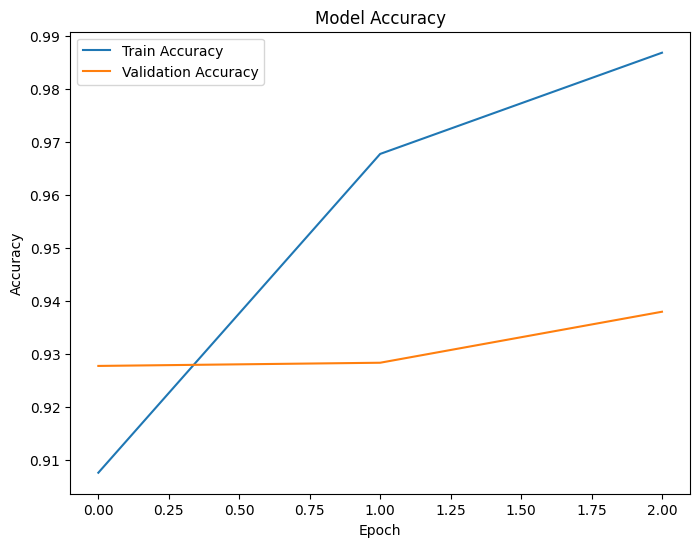

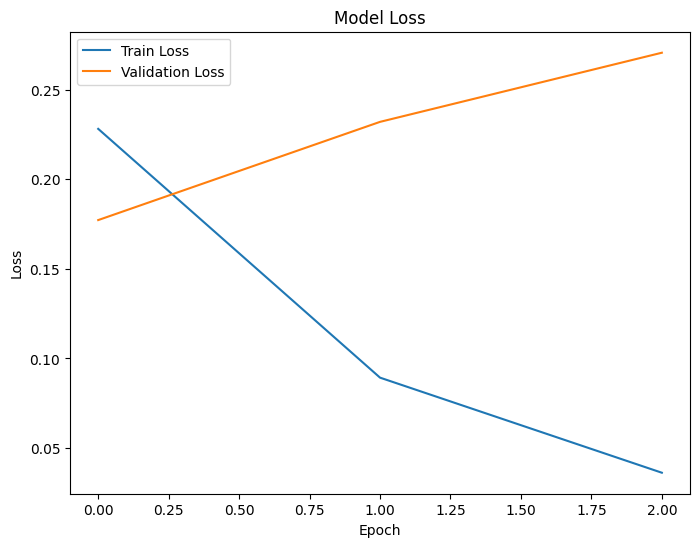

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


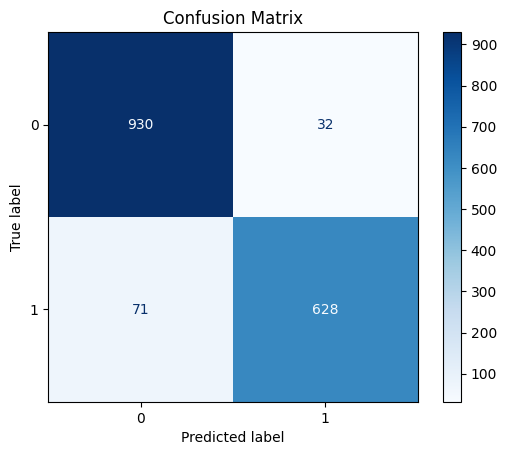

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
